In [56]:
import uproot
import numpy as np
#import scipy
#import scipy.misc
import pandas as pd
import os
import pickle
from readroot import *
import math

import matplotlib
import matplotlib.pyplot as plt

In [57]:
def chTruncation(file,evt_ID,evt_channels_arr=[],trun_channels_arr=[],evt_map=[]): 
    # function used to obtain PMT IDs which contain truncated pods for current event
    # --YQie, Feb. 2022
    
    # Obtain indexes for current event
    if (len(evt_map) == 0): evt_map = evt_index_mapper(file)
    index_of_interest = np.argwhere(evt_map[:,0] == evt_ID)[0][0]
    start_index = int(evt_map[index_of_interest][1])
    end_index = int(evt_map[index_of_interest][2])
    
    # Array contains truncation information for current event
    if (len(trun_channels_arr) == 0):
        evt_trun_channels = file['Data']['truncated'].array()[start_index:end_index]
    else:
        evt_trun_channels = trun_channels_arr[start_index:end_index]
        
    # Current PMT ID list
    if (len(evt_channels_arr) == 0):
        evt_channels = file['Data']['channel'].array()[start_index:end_index]
    else:
        evt_channels = evt_channels_arr[start_index:end_index]
        
    # Array of PMT IDs which contain truncated pods
    TruncatedChs = [v for i, v in enumerate(evt_channels) if evt_trun_channels[i]>0]
    return TruncatedChs

In [58]:
def PodEfficiencyNew(direc, pmtRaw_map, Type, evtnum):
    #function used to check the pod inconsistency between raw waveform and ZS pod
    #pod inconsistency represents the number of raw waveform for which there is a crossing but no ZS pod
    # --YQie, Feb. 2022
    
    # Read Zero&Unzero suppressed mapping and select PMTs
    Channel_map = pd.read_csv(pmtRaw_map)
    POD_array = np.array(Channel_map['POD'])
    RAW_array = np.array(Channel_map['RAW'])
    
    PMTs = []
    if(Type=="OD"):
        PMTs = np.arange(800,921,1)
    if(Type=="TPC"):
        PMTs = list(np.arange(0,253,1))+list(np.arange(290,541,1))
         
    ZSPmtID_array = []
    RawID_array = []
    for ind in range(len(POD_array)):
        if(POD_array[ind] in PMTs and RAW_array[ind] in PMTs):
            ZSPmtID_array.append(POD_array[ind])
            RawID_array.append(RAW_array[ind])

    # Array to store information and results: 
    # 0-num of total raw waveform, 1-num of total ZS pod, 
    # 2-num of raw waveform for which there is crossing and corresponding ZS pod, start time before that of ZS pod
    # 3-num of start time mismatch, 4-num of start time mismatch for which the crossing is exactly at 25 ADCC
    # 5-numb of raw waveform for which there is no crossing but ZS pod
    # 6-num of raw waveform which has start time after the start time of ZS pod
    # 7-num of raw waveform for which there is crossing but no corresponding ZS pod
    # 8-num of raw waveform for which there is crossing but no corresponding ZS pod and the crossing is at 25 ADCC
    # 9-num of raw waveform for which there is crossing but no corresponding ZS pod and the crossing is at less than 5 samples before the end time 
    Result = np.zeros(11)
    
    #count events
    evt_index = 0

    for filename in os.listdir(direc):
        if filename.endswith("raw.root"):
            fileIn = direc + "/" + filename
            file = uproot.open(fileIn)
            
            BufferStart = file['Event']['bufferStart'].array()
            BufferStop = file['Event']['bufferStop'].array()

            evt_map = evt_index_mapper(file)
            evt_ID = evt_map[:, 0]

            # Extract various data from the data file
            evt_channels_arr = file['Data']['channel'].array(library='np')
            evt_pulse_start_times_arr = file['Data']['startTime'].array(library='np')
            evt_raw_pulse_array_arr = file['Data']['zData'].array(library='np')
            truncatedPods = file['Data']['truncated'].array(library='np')

            for current_Evt in evt_ID:
                    
                evt_index += 1

                # Run for specific number of events
                if (evt_index > evtnum):
                    print(Result)
                    file.close()
                    return Result

                current_bufferStart = BufferStart[np.argwhere(file['Event']['globalEvt'].array()==int(current_Evt))[0]][0]
                current_bufferStop = BufferStop[np.argwhere(file['Event']['globalEvt'].array()==int(current_Evt))[0]][0]

                # Get relevant information for the current event.
                current_raw_pulse_array = raw_pulse_array(file, current_Evt, evt_raw_pulse_array_arr, evt_map)
                current_pulse_timing_map = pulse_timing_map(file, current_Evt, evt_pulse_start_times_arr, evt_map)
                current_ch_index_mapper = ch_index_mapper(file, current_Evt, evt_channels_arr, evt_map)
                pmt_ID = np.unique(current_ch_index_mapper)
                
                TruncatedCh = chTruncation(file,current_Evt,evt_channels_arr,truncatedPods,evt_map)
                
                # Go through each pmt storing raw waveform
                for i in range(len(RawID_array)):

                    if (RawID_array[i] in pmt_ID):

                        Result[0] += 1
                        
                        if(ZSPmtID_array[i] in pmt_ID): Result[1]+=1
                            
                        #If ZS pod is truncated, it's not considered
                        if(ZSPmtID_array[i] in TruncatedCh): continue
                            
                        # Obtain information of raw waveform
                        PMT_index_raw = np.argwhere(current_ch_index_mapper == RawID_array[i])
                        current_Pod_trace_raw = (current_raw_pulse_array[PMT_index_raw[0]])[0]
                        current_PMT_trace_t0_raw = (current_pulse_timing_map[PMT_index_raw[0]])[0]

                        # Invertion and baseline subtraction for the raw waveform
                        RawWaveInvert = [(-1) * v for v in current_Pod_trace_raw]
                        df = pd.DataFrame({'RawWave': RawWaveInvert})
                        df['baseline'] = df.rolling(window=32).mean()
                        Baseline = np.array(df.baseline)
                        Baseline = [math.floor(v) for v in Baseline if not np.isnan(v)]
                        PureWave = np.array(RawWaveInvert[34:]) - np.array(Baseline[:-3])

                        # At FPGA, the threshold is set as >= 25 ADCC
                        OverThre_index = [ind for ind, amp in enumerate(PureWave) if abs(amp) > 24.5]
                        
                        PMT_index_pod = np.argwhere(current_ch_index_mapper == ZSPmtID_array[i])

                        # For LED data, 10% raw waveform have pulses
                        if (OverThre_index == []): 
                            if(len(PMT_index_pod) > 0):
                                current_Pod_trace_pod = (current_raw_pulse_array[PMT_index_pod[0]])[0]
                                current_PMT_trace_t0_pod = (current_pulse_timing_map[PMT_index_pod[0]])[0]
                                if(current_PMT_trace_t0_pod<current_PMT_trace_t0_raw):
                                    #print(current_Evt,ZSPmtID_array[i],PMT_index_pod,current_PMT_trace_t0_pod,RawID_array[i],PMT_index_raw,current_PMT_trace_t0_raw)
                                    Result[6]+=1
                                    continue
                                Result[5] += 1
                                if(max(PureWave)>23.5):
                                    Result[10]+=1
                                else:
                                    print("max PureWave: "+str(max(PureWave)))
                                    print(current_Evt,ZSPmtID_array[i],RawID_array[i])
                                    timeddd = int(current_PMT_trace_t0_pod)-int(current_PMT_trace_t0_raw)
                                    podplotuse = list([np.nan]*timeddd)+list(current_Pod_trace_pod)+list([np.nan]*(len(current_Pod_trace_raw)-len(current_Pod_trace_pod)-timeddd))
                                    x_array = np.arange(0,len(current_Pod_trace_raw),1)
                                    plt.plot(x_array,current_Pod_trace_raw)
                                    plt.plot(x_array,podplotuse)
                                    plt.xlabel('Time (sample)')
                                    plt.ylabel('ADCC')
                                    plt.show()
                                    x_array = np.arange(34,len(PureWave)+34,1)
                                    plt.plot(x_array,PureWave)
                                    plt.axhline(y=25, color='g', linestyle='--',label='Threshold = 25 ADCC')
                                    plt.xlabel('Time (sample)')
                                    plt.ylabel('ADCC')
                                    plt.legend()
                                    plt.show()
                            continue

                        

                        # For the raw waveform, there is no corresponding ZS pod
                        if (len(PMT_index_pod) < 1):
                            Result[7] += 1
                            
                            # check whether the time of crossing is less than 5 samples before the end time
                            if((500-(OverThre_index[0]+34))<=5): Result[8]+=1

                            # check whether the crossing is at exactly 25 ADCC
                            elif (max(PureWave) < 25.5): Result[9] += 1
                                
                            else:
                                print("max PureWave: "+str(max(PureWave)))
                                print("Crossing at: "+str((500-(OverThre_index[0]+34))))
                                print(current_Evt,ZSPmtID_array[i],RawID_array[i])
                                x_array = np.arange(0,len(current_Pod_trace_raw),1)
                                plt.plot(x_array,current_Pod_trace_raw)
                                plt.xlabel('Time (sample)')
                                plt.ylabel('ADCC')
                                plt.show()
                                x_array = np.arange(34,len(PureWave)+34,1)
                                plt.plot(x_array,PureWave)
                                plt.axhline(y=25, color='g', linestyle='--',label='Threshold = 25 ADCC')
                                plt.xlabel('Time (sample)')
                                plt.ylabel('ADCC')
                                plt.legend()
                                plt.show()

                                
                            continue

                        # Obtain information of ZS pod
                        current_Pod_trace_pod = (current_raw_pulse_array[PMT_index_pod[0]])[0]
                        current_PMT_trace_t0_pod = (current_pulse_timing_map[PMT_index_pod[0]])[0]

                        # check whether the start time of raw waveform is after that of ZS pod
                        if (current_PMT_trace_t0_pod < current_PMT_trace_t0_raw): 
                            #print(current_Evt,ZSPmtID_array[i],PMT_index_pod,current_PMT_trace_t0_pod,RawID_array[i],PMT_index_raw,current_PMT_trace_t0_raw)
                            Result[6]+=1
                            continue

                        # Calculate start time of pulse from raw waveform and compare it with start time of ZS pod
                        RawPodTime = current_PMT_trace_t0_raw + OverThre_index[0] + 2
                        StartTimeDiff = RawPodTime - current_PMT_trace_t0_pod
    
                        if (abs(StartTimeDiff) > 0):
                            Result[3] += 1
                            # check whether the crossing is at exactly 25 or samples before crossing is at 24
                            if (24 in PureWave[OverThre_index[0] - 1:OverThre_index[0] + 2] or 25 in PureWave[OverThre_index[0] - 1:OverThre_index[0] + 2]):
                                Result[4] += 1
                        
                        Result[2] += 1

    file.close()
    return Result

In [59]:
directory = "/Users/yufanqie/Documents/LZ/6930"
even_map = "evenPOD.csv"
odd_map = "oddPOD.csv"
PMT_type = "OD" # "TPC" or "OD"
Num_evts = 1000

max PureWave: 26
Crossing at: 435
6.0 919 911


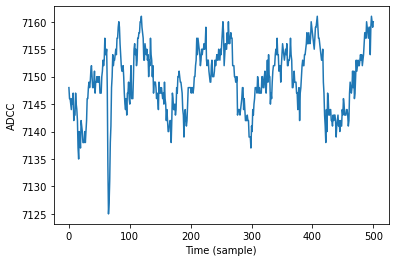

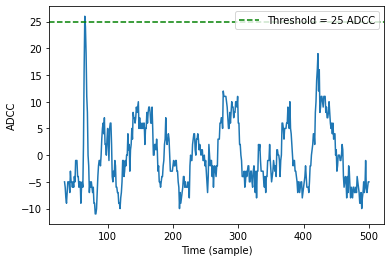

[5.6000e+04 3.5750e+04 3.6220e+03 6.3000e+01 5.4000e+01 4.0000e+00
 3.1986e+04 1.3000e+01 7.0000e+00 5.0000e+00 4.0000e+00]


In [60]:
EfficiencyResult = PodEfficiencyNew(directory,odd_map,PMT_type,Num_evts)